In [1]:
import sys
sys.path.append("../repo/KLens/")
sys.path.append("../repo/kl_measurement/")

In [2]:
import numpy as np
import os
import sys
import copy
from astropy.io import fits
import galsim
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import rotate
import tfCube
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def getSlitSpectra(data=None, pars=None):
    #weights = getSlitWeights(pars)
    spectra = []
    extent = pars['image_size'] * pars['pixScale']
    subGridPixScale = extent*1./pars['ngrid']
    grid = np.arange(-extent/2., extent/2., subGridPixScale)
    xx,yy = np.meshgrid(grid,grid)
    slit_weight = np.ones((pars['ngrid'],pars['ngrid']))
    slit_weight[np.abs(yy-pars['slitOffset']) > pars['slitWidth']/2.] = 0.
        
    for this_slit_angle in pars['slitAngles']:
        this_data = rotate(data, -this_slit_angle*(180./np.pi),reshape=False)
        spectra.append(np.sum(this_data*slit_weight[:,:,np.newaxis],axis=0))
    return spectra

In [111]:
pars = tfCube.getParams(redshift = 0.2)
pars['type_of_observation'] = 'slit'
# to make things practical during testing, increase the spaxel size.
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['nm_per_pixel'] = 0.025
pars['expTime'] = 10000.
pars['pixScale'] = 0.032
pars['Resolution'] = 5000
pars['sini'] = 1.
pars['aspect'] = 0.2
pars['vcirc'] = 200.
pars['area'] = 3.14*(1000./2.)**2
pars['linelist']['flux'][pars['linelist']['species'] == 'Halpha'] = 6e-24
pars['norm'] = 6e-24
pars['lambda_min'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] - 2
pars['lambda_max'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] + 2

pars['knot_fraction']=0.

lines = pars['linelist']
pars['half_light_radius'] = 0.5
#lines['flux'] = 1e-25 * 1e-9 # We seem to need another factor of 1e-9 here.
#pars['linelist'] = lines
pars['slitAngles'] = np.array([0.])#np.linspace(-np.pi/4., np.pi/2., 3)
pars['slitWidth']  = 0.3
pars['slitOffset'] = 0.0
# define some fiber parameters
#nfiber = 5
#r_off = 1.5
pars['fiber_size'] = 1.0
pars['psfFWHM'] = .25
pars['vscale'] = pars['half_light_radius']
pars['ngrid'] = 256
pars['image_size'] = 128

extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']

In [112]:
aperture = galsim.Image(pars['ngrid'], pars['ngrid'],scale=subGridPixScale)
obsLambda, obsGrid, modelGrid, skyGrid = tfCube.getTFcube(pars,aperture,[0.,0.])

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)


In [113]:
pars['slitOffset'] = 0.0
pars['slitWidth']  = 0.3
data0 = getSlitSpectra(data=modelGrid,pars=pars)
data0 = data0[0]

In [102]:
%run "../repo/kl_measurement/BinnedSummary/cal_velocity_1d.py"

# Start

In [114]:
data0.shape

(256, 160)

In [115]:
lambda0 = 656.461
redshift = 0.2
v_obs = lambda_to_velocity(lambda0,redshift,obsLambda) ; v_min = np.min(v_obs) ; v_MAX=np.max(v_obs)

In [116]:
peak_v = get_peak_velocity(data=data0,grid_v=v_obs)

## check slitOffset

In [127]:
pars['slitOffset'] = 0.0
pars['slitWidth']  = 0.3
data_00 = getSlitSpectra(data=modelGrid,pars=pars)

In [128]:
pars['slitOffset'] = 0.5
pars['slitWidth']  = 0.3
data_0i = getSlitSpectra(data=modelGrid,pars=pars)

In [129]:
peak_v_00 =  get_peak_velocity(data=data_00[0],grid_v=v_obs)
peak_v_0i =  get_peak_velocity(data=data_0i[0],grid_v=v_obs)

In [130]:
extent = pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
pos_grid = np.arange(-extent/2., extent/2., subGridPixScale) ; x_min=np.min(pos_grid) ; x_MAX=np.max(pos_grid)

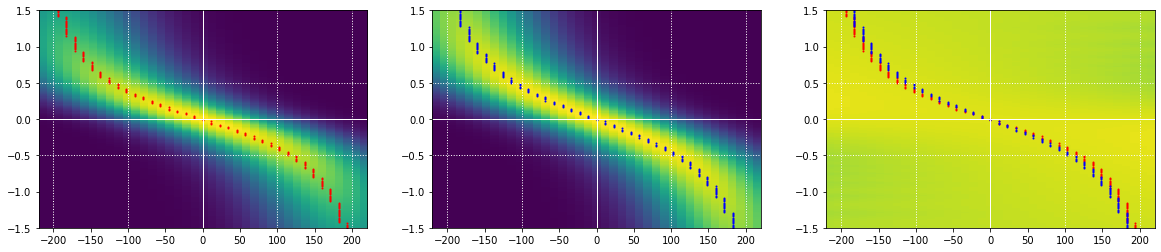

In [133]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,4))
#ax[0].imshow(np.sum(modelGrid,axis=2))
ax[0].imshow(data_00[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')
ax[1].imshow(data_0i[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')
ax[2].imshow((data_00[0]-data_0i[0])/data_00[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')

ax[0].plot(peak_v_00,np.flip(pos_grid),color='red' , marker='o', markersize=1,ls='none')
ax[1].plot(peak_v_0i,np.flip(pos_grid),color='blue', marker='o', markersize=1,ls='none')

ax[2].plot(peak_v_00,np.flip(pos_grid),color='red' , marker='o', markersize=1,ls='none')
ax[2].plot(peak_v_0i,np.flip(pos_grid),color='blue', marker='o', markersize=1,ls='none')




#ycen = (pars['lambda_min']+pars['lambda_max'])/2.
vcen = 0.

for j in range(ncol):
    ax[j].axhline(y=0.0,color='white', linestyle='-',lw=1)
    ax[j].axhline(y=0.5,color='white', linestyle=':',lw=1)
    ax[j].axhline(y=-0.5,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen,color='white', linestyle='-',lw=1)
    ax[j].axvline(x=vcen+100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen+200,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-200,color='white', linestyle=':',lw=1)
    
    ax[j].set_xlim(-220,220)
    ax[j].set_ylim(-1.5,1.5)

plt.show()

## check slitWidth

In [122]:
pars['slitOffset'] = 0.0
pars['slitWidth']  = 0.03
data_00 = getSlitSpectra(data=modelGrid,pars=pars)

In [123]:
pars['slitOffset'] = 0.0
pars['slitWidth']  = 0.6
data_0i = getSlitSpectra(data=modelGrid,pars=pars)

In [124]:
peak_v_00 =  get_peak_velocity(data=data_00[0],grid_v=v_obs)
peak_v_0i =  get_peak_velocity(data=data_0i[0],grid_v=v_obs)

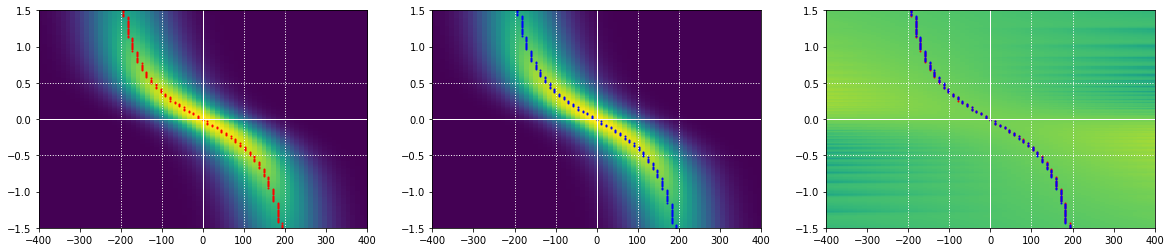

In [126]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,4))
#ax[0].imshow(np.sum(modelGrid,axis=2))
ax[0].imshow(data_00[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')
ax[1].imshow(data_0i[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')
ax[2].imshow((data_00[0]-data_0i[0])/data_00[0],extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')

ax[0].plot(peak_v_00,np.flip(pos_grid),color='red' , marker='o', markersize=1,ls='none')
ax[1].plot(peak_v_0i,np.flip(pos_grid),color='blue', marker='o', markersize=1,ls='none')

ax[2].plot(peak_v_00,np.flip(pos_grid),color='red' , marker='o', markersize=1,ls='none')
ax[2].plot(peak_v_0i,np.flip(pos_grid),color='blue', marker='o', markersize=1,ls='none')



#ycen = (pars['lambda_min']+pars['lambda_max'])/2.
vcen = 0.

for j in range(ncol):
    ax[j].axhline(y=0.0,color='white', linestyle='-',lw=1)
    ax[j].axhline(y=0.5,color='white', linestyle=':',lw=1)
    ax[j].axhline(y=-0.5,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen,color='white', linestyle='-',lw=1)
    ax[j].axvline(x=vcen+100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen+200,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-200,color='white', linestyle=':',lw=1)
    
    ax[j].set_xlim(-400,400)
    ax[j].set_ylim(-1.5,1.5)
    
plt.show()